# Prototype code for creating PSTH using fiber photometry data
* setup 12/11/2024 GT

In [1]:
from os.path import join
import pandas as pd
from src import TDT_experiment as tdt
import parse_cleanup_file
parse_cleanup_file.main()
import metadata
import matplotlib.pyplot as plt


In [2]:
#Test
def df_type_annotation(df: pd.DataFrame) -> pd.DataFrame:
    df["Frame"] = df["Frame"].astype(int)
    df["Shock"] = df["Shock"].astype(int)
    df["dFF"] = df["dFF"].astype(float)
    df["Freezing"] = df["Freezing"].astype(int)
    return df


def parse_mouse_id(series: pd.Series) -> pd.Series:
    series = series.str.split("_", expand=True)
    return series[0] + "_" + series[1]


def get_day1_data(folder_name):
    """
    Extracts and processes day 1 data from a specified folder.
    Parameters:
    folder_name (str): The name of the folder containing the experiment data.
    Returns:
    pandas.DataFrame: A DataFrame containing the processed data with columns:
                      - 'mouse_id': The ID of the mouse.
                      - 'dFF': The delta F/F values.
                      - 'Shock': The shock values.
    """
    exp = tdt.TDTExperiment(join(metadata.ROOT_DATA_DIR, folder_name))
    fiber_df = pd.read_csv(join(exp.analysis_path, "fiber_freezing_output.csv"))
    df_annot = df_type_annotation(fiber_df)
    df_annot["mouse_id"] = parse_mouse_id(df_annot["Mouse ID"])
    day1_data = df_annot[["mouse_id", "dFF", "Shock"]]

    return day1_data


def process_all_day1_data(day1_df):
    all_data = []

    # Iterate through the "Folder Name" column
    for folder_name in day1_df["Folder Name"]:
        result_df = get_day1_data(
            folder_name
        )  # This returns the filtered DataFrame (mouse_id, dFF, Shock)
        all_data.append(result_df)

    # Concatenate all individual DataFrames into one long DataFrame
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

In [3]:
df = pd.read_excel(metadata.GOOD_METADATA)
day1_df = df[df["day"] == "day_1"]
day1_df.reset_index(drop=True, inplace=True)

In [4]:
all_day1_data = process_all_day1_data(day1_df)

In [5]:
all_day1_data

,mouse_id,dFF,Shock
0,nia_08,0.016225,0
1,nia_08,0.360011,0
2,nia_08,0.314153,0
3,nia_08,-0.089399,0
4,nia_08,-0.486703,0
...,...,...,...
42721,nia_29,0.059994,0
42722,nia_29,-0.136814,0
42723,nia_29,-0.153798,0
42724,nia_29,0.073016,0


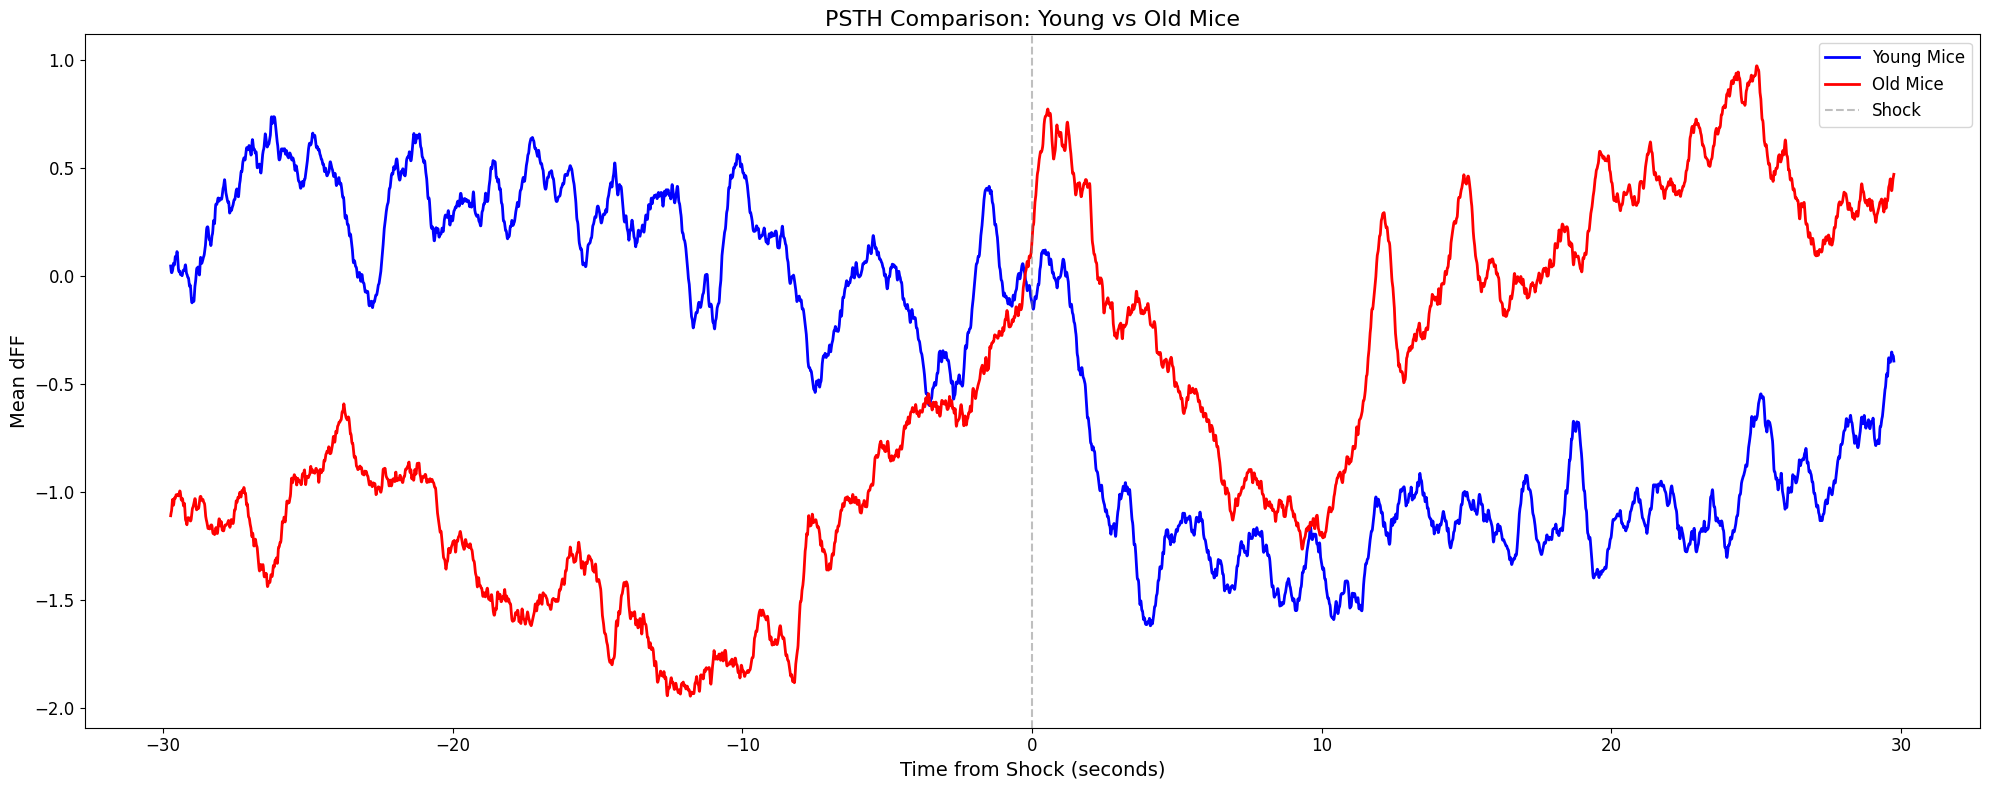

In [59]:
# Assume all_day1_data has columns:
# "Folder Name", "mouse_id", "dFF", "Shock"
# and possibly others.

# The column identifying each trial. Adjust as needed:
trial_column = "mouse_id"

# Time window around shock (in number of rows)
pre_shock = 3050  # rows before shock
post_shock = 3050  # rows after shock

# We'll store aligned data by age group
young_trials = []
old_trials = []

# Group by each trial
for trial_id, trial_df in all_day1_data.groupby(trial_column):
    # Get age group for this mouse_id from the original dataframe
    age_group = day1_df[day1_df['mouse_id'] == trial_id]['Age (binary)'].iloc[0]
    
    # Find the index of the shock event
    shock_indices = trial_df[trial_df["Shock"] == 100].index
    if len(shock_indices) != 1:
        continue

    shock_idx = shock_indices[0]
    start_idx = shock_idx - pre_shock
    end_idx = shock_idx + post_shock

    if start_idx < trial_df.index.min() or end_idx > trial_df.index.max():
        continue

    # Slice the trial data around the shock event
    window_df = trial_df.loc[start_idx:end_idx].copy()
    window_df["time_from_shock"] = window_df.index - shock_idx

    # Normalize based on a few points pre-shock
    baseline_mask = (window_df.index >= shock_idx - 50) & (window_df.index < shock_idx)
    baseline_mean = window_df.loc[baseline_mask, "dFF"].mean()
    window_df["dFF"] = window_df["dFF"] - baseline_mean

    # Sort into young or old trials
    if age_group == 'Young':
        young_trials.append(window_df[["time_from_shock", "dFF"]])
    else:
        old_trials.append(window_df[["time_from_shock", "dFF"]])

# Create separate PSTHs for young and old
if not young_trials or not old_trials:
    raise ValueError("No aligned data found for one or both age groups; check data and shock events.")

young_df = pd.concat(young_trials, ignore_index=True)
old_df = pd.concat(old_trials, ignore_index=True)

young_psth = young_df.groupby("time_from_shock")["dFF"].mean().reset_index()
old_psth = old_df.groupby("time_from_shock")["dFF"].mean().reset_index()

# Create one plot with both traces overlaid, but smoothed for clarity
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# Convert fiber frames to seconds
frames_to_seconds = 0.00983123054  # conversion factor

# Apply rolling average to smooth the data
window_size = 50
young_smooth = young_psth["dFF"].rolling(window=window_size, center=True).mean()
old_smooth = old_psth["dFF"].rolling(window=window_size, center=True).mean()

# Plot with converted x-axis
ax.plot(young_psth["time_from_shock"] * frames_to_seconds, young_smooth, color='blue', label='Young Mice', linewidth=2)
ax.plot(old_psth["time_from_shock"] * frames_to_seconds, old_smooth, color='red', label='Old Mice', linewidth=2)

# Add shock line
ax.axvline(0, color="gray", linestyle="--", alpha=0.5, label="Shock")

# Update x-label to show seconds instead of samples
ax.set_xlabel("Time from Shock (seconds)", fontsize=14)
ax.set_ylabel("Mean dFF", fontsize=14)
ax.set_title("PSTH Comparison: Young vs Old Mice", fontsize=16)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

In [48]:
print("Number of trials in each group:")
print(f"Young mice: {len(young_trials)}")
print(f"Old mice: {len(old_trials)}")
print("\nMean baseline dFF (pre-shock):")
young_baseline = young_df[young_df['time_from_shock'] < 0]['dFF'].mean()
old_baseline = old_df[old_df['time_from_shock'] < 0]['dFF'].mean()
print(f"Young mice baseline: {young_baseline:.4f}")
print(f"Old mice baseline: {old_baseline:.4f}")

Number of trials in each group:
Young mice: 3
Old mice: 4

Mean baseline dFF (pre-shock):
Young mice baseline: -0.0647
Old mice baseline: -0.1157


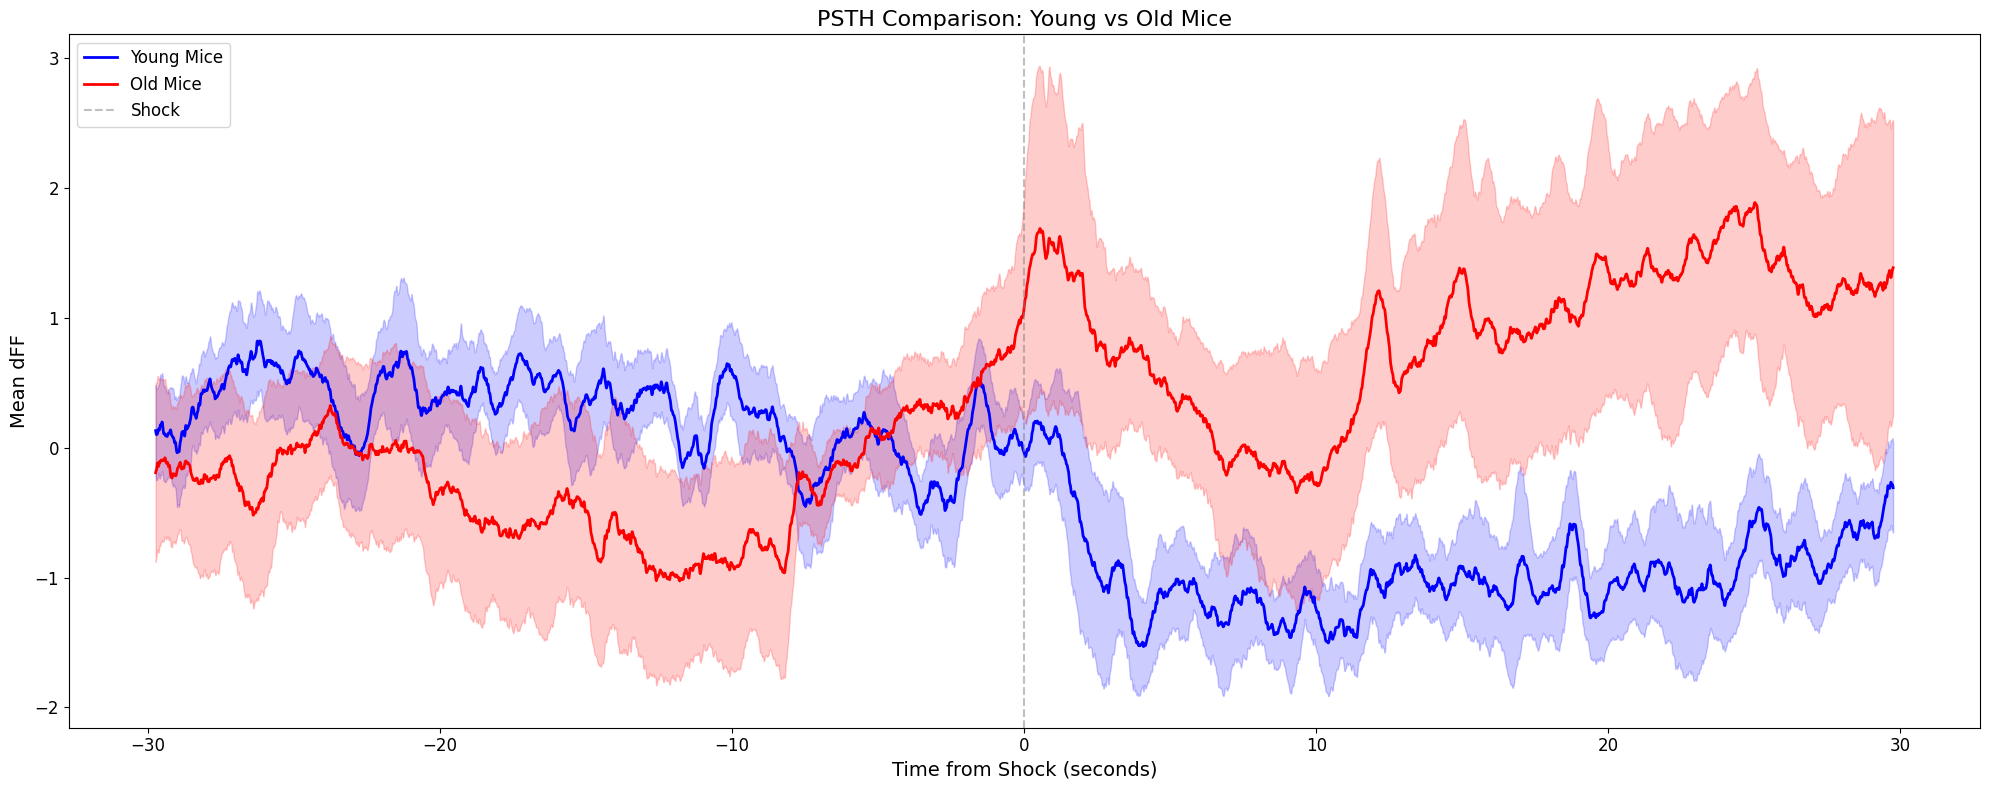

In [78]:
# Assume all_day1_data has columns:
# "Folder Name", "mouse_id", "dFF", "Shock"
# and possibly others.

# The column identifying each trial. Adjust as needed:
trial_column = "mouse_id"

# Time window around shock (in number of rows)
pre_shock = 3050  # rows before shock
post_shock = 3050  # rows after shock

# We'll store aligned data by age group
young_trials = []
old_trials = []

# Group by each trial
for trial_id, trial_df in all_day1_data.groupby(trial_column):
    # Get age group for this mouse_id from the original dataframe
    age_group = day1_df[day1_df['mouse_id'] == trial_id]['Age (binary)'].iloc[0]
    
    # Find the index of the shock event
    shock_indices = trial_df[trial_df["Shock"] == 100].index
    if len(shock_indices) != 1:
        continue

    shock_idx = shock_indices[0]
    start_idx = shock_idx - pre_shock
    end_idx = shock_idx + post_shock

    if start_idx < trial_df.index.min() or end_idx > trial_df.index.max():
        continue

    # Slice the trial data around the shock event
    window_df = trial_df.loc[start_idx:end_idx].copy()
    window_df["time_from_shock"] = window_df.index - shock_idx

    # Normalize based on a few points pre-shock
    # Modified for 5 seconds (since frames_to_seconds = 0.00983123054)
    seconds_to_frames = 1/0.00983123054  # convert seconds to frames
    baseline_mask = (window_df.index >= shock_idx - (10 * seconds_to_frames)) & (window_df.index < shock_idx)
    baseline_mean = window_df.loc[baseline_mask, "dFF"].mean()
    window_df["dFF"] = window_df["dFF"] - baseline_mean

    # Sort into young or old trials
    if age_group == 'Young':
        young_trials.append(window_df[["time_from_shock", "dFF"]])
    else:
        old_trials.append(window_df[["time_from_shock", "dFF"]])

# Create separate PSTHs for young and old
if not young_trials or not old_trials:
    raise ValueError("No aligned data found for one or both age groups; check data and shock events.")

young_df = pd.concat(young_trials, ignore_index=True)
old_df = pd.concat(old_trials, ignore_index=True)

young_psth = young_df.groupby("time_from_shock")["dFF"].mean().reset_index()
old_psth = old_df.groupby("time_from_shock")["dFF"].mean().reset_index()

# Create one plot with both traces overlaid, but smoothed for clarity
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# Convert fiber frames to seconds
frames_to_seconds = 0.00983123054  # conversion factor

young_sem = young_df.groupby("time_from_shock")["dFF"].sem().reset_index()
old_sem = old_df.groupby("time_from_shock")["dFF"].sem().reset_index()

# Apply smoothing to mean and SEM
window_size = 50
young_smooth = young_psth["dFF"].rolling(window=window_size, center=True).mean()
old_smooth = old_psth["dFF"].rolling(window=window_size, center=True).mean()
young_sem_smooth = young_sem["dFF"].rolling(window=window_size, center=True).mean()
old_sem_smooth = old_sem["dFF"].rolling(window=window_size, center=True).mean()

# Plot means and confidence intervals
x_young = young_psth["time_from_shock"] * frames_to_seconds
x_old = old_psth["time_from_shock"] * frames_to_seconds

# Plot confidence intervals
ax.fill_between(x_young, young_smooth - young_sem_smooth, young_smooth + young_sem_smooth, 
                color='blue', alpha=0.2)
ax.fill_between(x_old, old_smooth - old_sem_smooth, old_smooth + old_sem_smooth, 
                color='red', alpha=0.2)

# Plot mean lines
ax.plot(x_young, young_smooth, color='blue', label='Young Mice', linewidth=2)
ax.plot(x_old, old_smooth, color='red', label='Old Mice', linewidth=2)

# Rest of the plotting code stays the same
ax.axvline(0, color="gray", linestyle="--", alpha=0.5, label="Shock")
ax.set_xlabel("Time from Shock (seconds)", fontsize=14)
ax.set_ylabel("Mean dFF", fontsize=14)
ax.set_title("PSTH Comparison: Young vs Old Mice", fontsize=16)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()